In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Activation, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import LambdaCallback
from sklearn import tree
from sklearn.metrics import confusion_matrix
import itertools
import time
import multiprocessing
from pickle import dump


%matplotlib inline

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# gpus = tf.config.experimental.list_physical_devices(device_type='CPU')
# print(gpus)

In [2]:
pwd = os.getcwd()
all_file_names = []
scenarios = ['scenario'+str(i+1) for i in range(5)]
data_dist_table = pd.DataFrame(index=['Hold','Takeoff','Hover','Search','Loiter','Obstacleavoid','Land'])
for scenario in scenarios:
    count_dict = {'Hold':0,'Takeoff':0,'Hover':0,'Search':0,'Loiter':0,'Obstacleavoid':0,'Land':0}
    database_path = pwd[:-6] + "flightData/filtered_data/"+scenario
    database_file_names = []
    for root, dirs, files in os.walk(database_path):
        database_file_names = [os.path.join(root,file) for file in files]
    all_file_names += database_file_names
    for file in database_file_names:
        data = pd.read_csv(file)
        label_count = data['label'].value_counts()
        for indx in label_count.index:
            count_dict[indx] += label_count[indx]
    data_dist_table[scenario] = count_dict.values()
print(data_dist_table)            

               scenario1  scenario2  scenario3  scenario4  scenario5
Hold               13264      13287      64310      57328      23519
Takeoff             1813       1844       1900       1858       1801
Hover               9001       9000       9045       9001       9014
Search                 0     109788     204655     541196     319726
Loiter                 0          0      83451          0      51460
Obstacleavoid          0          0          0      17441      11533
Land                1940       2088       1986       1848       1896


In [4]:
# plt.figure(figsize=(18,16))
# # for i,file in enumerate(database_file_names):
# file = database_file_names[0]
# data = pd.read_csv(file)
# # i=1
# col = data.columns[0]
# # for col in data.columns:
# #     if col=='time':
# #         continue
# x = data['time'].values
# for i,col in enumerate(data.columns):
#     y = data[col].values
#     plt.subplot(7,2,i+1)
#     plt.plot(x,y,label=col)
#     plt.grid()
#     plt.legend()
# #     i=i+1
# #         data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
# #         data.to_csv(file,index=False)
# #     old_label = pd.unique(data['label'])
# #     print(old_label)
# #     new_label = [j for j in range(1,len(old_label)+1)]
# #     data = data.replace(old_label, new_label)
# #     #     print(file)
# #     x = data['x'].values
# #     y = data['y'].values
# #     t = data['time'].values
# #     label = data['label'].values
# # #     label[22800:25350] = 4
# #     label = label*10
# #     plt.subplot(25,2,i+1)
# #     #     plt.plot(t,x)
# #     indx = 0
# #     plt.plot(y[indx:])
# #     plt.plot(label[indx:])
# #     plt.grid()
# #     file_name = file.split("/")
# #     file_name = file_name[-1]
# #     plt.title(file_name)

# # newfile = file[:-4]+'_new.csv'
# # data = data.replace(new_label, old_label)
# # data.to_csv(newfile, index=False)

# #     print(i)

In [5]:
# data.head()
# print(x[1]-x[0])
# print(x[2]-x[1])
# print(x[3]-x[1])

In [6]:
# print([i for i in range(1,len(pd.unique(data['label']))+1)])

In [7]:
# print(pd.unique(data['label']))

In [8]:
# print(file[:-4]+'_new.csv')

In [9]:
# X_train = data.drop(columns=['label', 'time'])
# X_train = X_train.values
# print(X_train.shape)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# Y_train = data['label'].values
# Y_train = Y_train.reshape((-1,1))
# encoder = OneHotEncoder()
# Y_train = encoder.fit_transform(Y_train).toarray()
# print(Y_train.shape)
# print(Y_train[0,:])

In [21]:
def batch_gen(X,y,time_step,batch_size=64):
    i = 0
    m = X.shape[0]
    print("Total train samples {}".format(m))
    
    while True:
        x_batch = []
        y_batch = []
        
        for j in range(batch_size):
            if i+j+time_step == m:
                i = -1
                break
            x_batch.append(X[i+j:i+j+time_step,:])
            y_batch.append(y[i+j+time_step,:])
        
        yield (np.array(x_batch), np.array(y_batch), i)
        i = i+1
        
        
def batch_gen_MLP(X,y,time_step,batch_size=64):
    m = X.shape[0]
    n = y.shape[1]
    i = 0
    while True:
        x_batch = []
        y_batch = [] 
        for j in range(batch_size):
            if i+j+time_step == m:
                i = -1
                break
            x_batch.append((X[i+j:i+j+time_step,:]).reshape((1,-1)))
            arg = np.argmax(np.sum(y[i+j:i+j+time_step,:], axis=0))
            label = np.zeros((1,n))
            label[0,arg] = 1.0
            y_batch.append(label)
        if i != -1:
            x_batch = (np.array(x_batch)).reshape((batch_size,-1))
            y_batch = (np.array(y_batch)).reshape((batch_size,-1))
        else:
            x_batch = (np.array(x_batch)).reshape((j,-1))
            y_batch = (np.array(y_batch)).reshape((j,-1))
        
        yield (x_batch, y_batch, i)
        i = i+1

def batch_gen_mlp(X,y,batch_size=64):
    m = X.shape[0]
    flag = 0
    i = 0
    while True:
        yield (X[i*batch_size:(i+1)*batch_size,:], y[i*batch_size:(i+1)*batch_size,:], (-1 if ((i+1)*batch_size > m) else 0))
        i += 1
        if i*batch_size > m:
            i = 0

In [5]:
# scaler = MinMaxScaler()
# encoder = OneHotEncoder()
# error = []
# file = database_file_names[0]
# data = pd.read_csv(file)
# X_train = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
# X_train = X_train.values
# Y_train = data['label'].values
# Y_train = Y_train.reshape((-1,1))

# X_train = scaler.fit_transform(X_train)
# Y_train = encoder.fit_transform(Y_train).toarray()

# #data_gen = batch_gen(X_train, Y_train, 32, 512)

# dataset = Dataset.from_generator(batch_gen, (tf.dtypes.variant,tf.dtypes.variant,tf.dtypes.int64))

# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [4]:
# # deep LSTM model
# time_step = 64
# num_feature = 7
# num_class = 7
# bi = '1'
# neuron_size = 128
# lstm_layer = 1


# # x_in = Input(shape=(time_step, num_feature),dtype="float32")
# # x, _, _ = LSTM(units=64, return_sequences=True, return_state=True, activation='tanh')(x_in)
# # x, _, _ = LSTM(units=128, return_sequences=True, return_state=True, activation='tanh')(x)
# # _, _, x = LSTM(units=64, return_sequences=True, return_state=True, activation='tanh')(x)
# # x = Dense(units=128, activation="softmax")(x)
# # x = Dense(units=256, activation="softmax")(x)
# # y = Dense(units=num_class, activation="softmax")(x)

# # whole_sequence_output, final_state
# # x_in = Input(shape=(num_feature),dtype="float32")
# # x = Dense(units=64, activation="relu")(x_in)
# # x = Dense(units=128, activation="relu")(x)
# # x = Dense(units=64, activation="relu")(x)
# # y = Dense(units=num_class, activation="softmax")(x)

# x_in = Input(shape=(time_step,num_feature),dtype="float32")
# # forward_layer = LSTM(units=128, return_sequences=True, activation='tanh')
# # backward_layer = LSTM(units=128, return_sequences=True, activation='tanh', go_backwards=True)
# # bid_layer1 = Bidirectional(layer=forward_layer,backward_layer=backward_layer, merge_mode='concat')(x_in)
# bid_layer2 = Bidirectional(LSTM(neuron_size))(x_in)
# # x = Dense(units=128, activation="relu")(bid_layer[:,-1,:])
# # x = Dense(units=256, activation="relu")(x)
# y = Dense(units=num_class, activation='softmax')(bid_layer2)

# model = Model(inputs=x_in, outputs=y)
# optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# # loss_fn = losses.CategoricalCrossentropy(from_logits=True)
# # train_acc_metric = metrics.CategoricalAccuracy()
# loss = losses.categorical_crossentropy
# model.compile(optimizer=optimizer, loss=loss, metrics=['CategoricalAccuracy'])
# model.summary()

In [16]:
# #create LSTM model
# num_feature = 7
# time_step = 32
# num_class = 7
# x_in = Input(shape=(time_step,num_feature),dtype="float32")
# forward_layer = LSTM(units=128, return_sequences=True, activation='tanh')
# backward_layer = LSTM(units=128, return_sequences=True, activation='tanh', go_backwards=True)
# bid_layer = Bidirectional(layer=forward_layer,backward_layer=backward_layer, merge_mode='concat')(x_in)
# y = Dense(units=num_class,activation='softmax')(bid_layer[:,-1,:])
# model = Model(inputs=x_in,outputs=y)
# optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# loss_fn = losses.CategoricalCrossentropy(from_logits=True)
# train_acc_metric = metrics.CategoricalAccuracy()
# #loss = losses.categorical_crossentropy
# #model.compile(optimizer=optimizer, loss=loss, metrics=['CategoricalAccuracy'])


In [23]:
# class Process(multiprocessing.Process): 
#     def __init__(self, id, model,loss_fn, x_batch_train, y_batch_train): 
#         super(Process, self).__init__() 
#         self.id = id
#         self.grads = None
#         self.model = model
#         self.loss_fn = loss_fn
#         self.x_batch_train = x_batch_train
#         self.y_batch_train = y_batch_train
                 
#     def run(self): 
#         with tf.GradientTape() as tape:
#                 logits = self.model(self.x_batch_train, training=True)
#                 loss_value = self.loss_fn(self.y_batch_train, logits)
#         self.grads = tape.gradient(loss_value, self.model.trainable_weights)

In [3]:
scaler = MinMaxScaler()
encoder = OneHotEncoder()
pwd = os.getcwd()
database_path = pwd[:-6] + "flightData/filtered_data/scenario5"
database_file_names = []
for root, dirs, files in os.walk(database_path):
    database_file_names = [os.path.join(root,file) for file in files]

data = pd.read_csv(database_file_names[0])
X_train = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
X_train = X_train.values
Y_train = data['label'].values
Y_train = Y_train.reshape((-1,1))
_ = scaler.fit_transform(X_train)
_ = encoder.fit_transform(Y_train).toarray()
# save the scaler
#dump(scaler, open('scaler.pkl', 'wb'),protocol=2)
# save the encoder
#dump(encoder, open('encoder.pkl', 'wb'),protocol=2)

In [4]:
%%time

# training

# deep LSTM model
time_steps = [32, 64, 128]
num_features = [7,9]
num_class = 7
direction = 2
neuron_sizes = [64, 128, 256, 512]
lstm_layers = 1

for time_step in time_steps:
    for num_feature in num_features:
        for neuron_size in neuron_sizes:
            # create model
            x_in = Input(shape=(time_step,num_feature),dtype="float32")
            bid_layer1 = Bidirectional(LSTM(neuron_size))(x_in)
            y = Dense(units=num_class, activation='softmax')(bid_layer1)

            model = Model(inputs=x_in, outputs=y)
            optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
            loss = losses.categorical_crossentropy
            model.compile(optimizer=optimizer, loss=loss, metrics=['CategoricalAccuracy'])


            # load dataset
            pwd = os.getcwd()
            model_path = pwd+'/models/'

            batch_print_callback = LambdaCallback(on_batch_end=lambda batch,logs: print(batch, logs))

            pwd = os.getcwd()
            database_path = pwd[:-6] + "flightData/filtered_data/scenario5"
            database_file_names = []
            for root, dirs, files in os.walk(database_path):
                database_file_names = [os.path.join(root,file) for file in files]

            scaler = MinMaxScaler()
            encoder = OneHotEncoder()
            
            #training loop
            for model_no in range(1,71):
                for i,file in enumerate(database_file_names):
                    data = pd.read_csv(file)
                    if num_feature == 7:
                        X_train = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
                    else:
                        X_train = data.drop(columns=['label', 'time','pitch_v','roll_v','yaw_v'])

                    X_train = X_train.values
                    Y_train = data['label'].values
                    Y_train = Y_train.reshape((-1,1))
                    if i == 0:
                        X_train = scaler.fit_transform(X_train)
                        Y_train = encoder.fit_transform(Y_train).toarray()
                    else:
                        X_train = scaler.transform(X_train)
                        Y_train = encoder.transform(Y_train).toarray()

                    input_data = X_train[:-time_step,:]
                    targets = Y_train[time_step:,:]
                    dataset = timeseries_dataset_from_array(input_data, 
                                                            targets, 
                                                            sequence_length=time_step,
                                                            batch_size=128)
                    hist = model.fit(dataset,
                                     epochs=10,
                                     verbose=2,
                                     callbacks=None,#[batch_print_callback],
                                     max_queue_size=512,
                                     workers=80,
                                     use_multiprocessing=True)

                model_name = 'lstm_direction_' + str(direction)\
                             + '_layers_' + str(lstm_layers)\
                             + '_features_' + str(num_feature)\
                             + '_neurons_' + str(neuron_size)\
                             + '_timesteps_' + str(time_step)\
                             + '_epochs_' + str((model_no)*10) + '.h5'
                model.save(model_path+model_name) 


Epoch 1/10
602/602 - 18s - loss: 0.7840 - categorical_accuracy: 0.7440
Epoch 2/10
602/602 - 14s - loss: 0.6658 - categorical_accuracy: 0.7410
Epoch 3/10
602/602 - 14s - loss: 0.6694 - categorical_accuracy: 0.7370
Epoch 4/10
602/602 - 14s - loss: 0.6045 - categorical_accuracy: 0.7439
Epoch 5/10
602/602 - 14s - loss: 0.6230 - categorical_accuracy: 0.7522
Epoch 6/10
602/602 - 14s - loss: 0.6372 - categorical_accuracy: 0.7493
Epoch 7/10
602/602 - 14s - loss: 0.5873 - categorical_accuracy: 0.7648
Epoch 8/10
602/602 - 14s - loss: 0.5160 - categorical_accuracy: 0.8302
Epoch 9/10
602/602 - 14s - loss: 0.4736 - categorical_accuracy: 0.8520
Epoch 10/10
602/602 - 14s - loss: 0.4820 - categorical_accuracy: 0.8640
Epoch 1/10
859/859 - 20s - loss: 0.2698 - categorical_accuracy: 0.9087
Epoch 2/10
859/859 - 20s - loss: 0.3354 - categorical_accuracy: 0.8801
Epoch 3/10
859/859 - 20s - loss: 0.3096 - categorical_accuracy: 0.8888
Epoch 4/10
859/859 - 20s - loss: 0.3081 - categorical_accuracy: 0.8937
Epoch

Epoch 7/10
859/859 - 21s - loss: 0.1455 - categorical_accuracy: 0.9293
Epoch 8/10
859/859 - 21s - loss: 0.1313 - categorical_accuracy: 0.9303
Epoch 9/10
859/859 - 21s - loss: 0.1705 - categorical_accuracy: 0.9200
Epoch 10/10
859/859 - 21s - loss: 0.1364 - categorical_accuracy: 0.9347
Epoch 1/10
903/903 - 23s - loss: 0.1667 - categorical_accuracy: 0.9331
Epoch 2/10
903/903 - 22s - loss: 0.1532 - categorical_accuracy: 0.9310
Epoch 3/10
903/903 - 23s - loss: 0.1332 - categorical_accuracy: 0.9339
Epoch 4/10
903/903 - 23s - loss: 0.1286 - categorical_accuracy: 0.9381
Epoch 5/10
903/903 - 23s - loss: 0.1219 - categorical_accuracy: 0.9454
Epoch 6/10
903/903 - 22s - loss: 0.2348 - categorical_accuracy: 0.9253
Epoch 7/10
903/903 - 22s - loss: 0.3175 - categorical_accuracy: 0.9121
Epoch 8/10
903/903 - 22s - loss: 0.2362 - categorical_accuracy: 0.9021
Epoch 9/10
903/903 - 22s - loss: 0.1585 - categorical_accuracy: 0.9222
Epoch 10/10
903/903 - 22s - loss: 0.1717 - categorical_accuracy: 0.9320
Epoc

Epoch 3/10
466/466 - 11s - loss: 0.0935 - categorical_accuracy: 0.9663
Epoch 4/10
466/466 - 11s - loss: 0.1396 - categorical_accuracy: 0.9547
Epoch 5/10
466/466 - 11s - loss: 0.3313 - categorical_accuracy: 0.8820
Epoch 6/10
466/466 - 11s - loss: 0.7653 - categorical_accuracy: 0.8194
Epoch 7/10
466/466 - 11s - loss: 0.3556 - categorical_accuracy: 0.8507
Epoch 8/10
466/466 - 11s - loss: 0.2328 - categorical_accuracy: 0.8798
Epoch 9/10
466/466 - 11s - loss: 0.2028 - categorical_accuracy: 0.9134
Epoch 10/10
466/466 - 11s - loss: 0.1794 - categorical_accuracy: 0.9169
Epoch 1/10
434/434 - 11s - loss: 0.1684 - categorical_accuracy: 0.9297
Epoch 2/10
434/434 - 11s - loss: 0.1458 - categorical_accuracy: 0.9369
Epoch 3/10
434/434 - 11s - loss: 0.1518 - categorical_accuracy: 0.9409
Epoch 4/10
434/434 - 11s - loss: 0.9079 - categorical_accuracy: 0.8728
Epoch 5/10
434/434 - 11s - loss: 0.5800 - categorical_accuracy: 0.8224
Epoch 6/10
434/434 - 11s - loss: 0.2680 - categorical_accuracy: 0.9073
Epoch

Epoch 9/10
434/434 - 11s - loss: 0.0929 - categorical_accuracy: 0.9560
Epoch 10/10
434/434 - 11s - loss: 0.1560 - categorical_accuracy: 0.9312
Epoch 1/10
602/602 - 15s - loss: 0.1196 - categorical_accuracy: 0.9585
Epoch 2/10
602/602 - 15s - loss: 0.0898 - categorical_accuracy: 0.9656
Epoch 3/10
602/602 - 15s - loss: 0.0730 - categorical_accuracy: 0.9717
Epoch 4/10
602/602 - 15s - loss: 0.0757 - categorical_accuracy: 0.9724
Epoch 5/10
602/602 - 15s - loss: 0.1200 - categorical_accuracy: 0.9607
Epoch 6/10
602/602 - 15s - loss: 0.0672 - categorical_accuracy: 0.9736
Epoch 7/10
602/602 - 15s - loss: 0.0547 - categorical_accuracy: 0.9841
Epoch 8/10
602/602 - 15s - loss: 0.0549 - categorical_accuracy: 0.9829
Epoch 9/10
602/602 - 15s - loss: 0.0772 - categorical_accuracy: 0.9757
Epoch 10/10
602/602 - 15s - loss: 0.2908 - categorical_accuracy: 0.8969
Epoch 1/10
859/859 - 21s - loss: 0.0922 - categorical_accuracy: 0.9594
Epoch 2/10
859/859 - 21s - loss: 0.0794 - categorical_accuracy: 0.9684
Epoc

Epoch 5/10
859/859 - 21s - loss: 0.0221 - categorical_accuracy: 0.9930
Epoch 6/10
859/859 - 21s - loss: 0.0204 - categorical_accuracy: 0.9936
Epoch 7/10
859/859 - 21s - loss: 0.0214 - categorical_accuracy: 0.9932
Epoch 8/10
859/859 - 21s - loss: 0.0239 - categorical_accuracy: 0.9924
Epoch 9/10
859/859 - 21s - loss: 0.0310 - categorical_accuracy: 0.9869
Epoch 10/10
859/859 - 21s - loss: 0.0322 - categorical_accuracy: 0.9897
Epoch 1/10
903/903 - 22s - loss: 0.0297 - categorical_accuracy: 0.9929
Epoch 2/10
903/903 - 22s - loss: 0.1000 - categorical_accuracy: 0.9640
Epoch 3/10
903/903 - 22s - loss: 0.0779 - categorical_accuracy: 0.9733
Epoch 4/10
903/903 - 22s - loss: 0.0482 - categorical_accuracy: 0.9840
Epoch 5/10
903/903 - 22s - loss: 0.0330 - categorical_accuracy: 0.9898
Epoch 6/10
903/903 - 22s - loss: 0.0422 - categorical_accuracy: 0.9861
Epoch 7/10
903/903 - 22s - loss: 0.0489 - categorical_accuracy: 0.9815
Epoch 8/10
903/903 - 22s - loss: 0.0698 - categorical_accuracy: 0.9765
Epoch

Epoch 1/10
466/466 - 12s - loss: 0.0775 - categorical_accuracy: 0.9800
Epoch 2/10
466/466 - 11s - loss: 0.1660 - categorical_accuracy: 0.9484
Epoch 3/10
466/466 - 11s - loss: 0.0743 - categorical_accuracy: 0.9717
Epoch 4/10
466/466 - 11s - loss: 0.0397 - categorical_accuracy: 0.9870
Epoch 5/10
466/466 - 11s - loss: 0.0384 - categorical_accuracy: 0.9868
Epoch 6/10
466/466 - 11s - loss: 0.0402 - categorical_accuracy: 0.9876
Epoch 7/10
466/466 - 11s - loss: 0.0403 - categorical_accuracy: 0.9869
Epoch 8/10
466/466 - 12s - loss: 0.0339 - categorical_accuracy: 0.9873
Epoch 9/10
466/466 - 11s - loss: 0.0367 - categorical_accuracy: 0.9859
Epoch 10/10
466/466 - 12s - loss: 0.1098 - categorical_accuracy: 0.9618
Epoch 1/10
434/434 - 11s - loss: 0.1425 - categorical_accuracy: 0.9385
Epoch 2/10
434/434 - 11s - loss: 0.4331 - categorical_accuracy: 0.8946
Epoch 3/10
434/434 - 11s - loss: 0.2559 - categorical_accuracy: 0.8966
Epoch 4/10
434/434 - 11s - loss: 0.1424 - categorical_accuracy: 0.9356
Epoch

Epoch 7/10
434/434 - 11s - loss: 0.0245 - categorical_accuracy: 0.9927
Epoch 8/10
434/434 - 11s - loss: 0.0234 - categorical_accuracy: 0.9929
Epoch 9/10
434/434 - 11s - loss: 0.0183 - categorical_accuracy: 0.9932
Epoch 10/10
434/434 - 11s - loss: 0.0213 - categorical_accuracy: 0.9923
Epoch 1/10
602/602 - 15s - loss: 0.0985 - categorical_accuracy: 0.9748
Epoch 2/10
602/602 - 15s - loss: 0.2209 - categorical_accuracy: 0.9378
Epoch 3/10
602/602 - 15s - loss: 0.0746 - categorical_accuracy: 0.9764
Epoch 4/10
602/602 - 15s - loss: 0.0809 - categorical_accuracy: 0.9708
Epoch 5/10
602/602 - 15s - loss: 0.0455 - categorical_accuracy: 0.9821
Epoch 6/10
602/602 - 15s - loss: 0.0666 - categorical_accuracy: 0.9694
Epoch 7/10
602/602 - 15s - loss: 0.0450 - categorical_accuracy: 0.9864
Epoch 8/10
602/602 - 15s - loss: 0.0329 - categorical_accuracy: 0.9923
Epoch 9/10
602/602 - 15s - loss: 0.0335 - categorical_accuracy: 0.9900
Epoch 10/10
602/602 - 15s - loss: 0.0303 - categorical_accuracy: 0.9900
Epoc

Epoch 3/10
859/859 - 21s - loss: 0.0293 - categorical_accuracy: 0.9910
Epoch 4/10
859/859 - 21s - loss: 0.0210 - categorical_accuracy: 0.9913
Epoch 5/10
859/859 - 21s - loss: 0.0158 - categorical_accuracy: 0.9952
Epoch 6/10
859/859 - 21s - loss: 0.0157 - categorical_accuracy: 0.9939
Epoch 7/10
859/859 - 21s - loss: 0.0162 - categorical_accuracy: 0.9945
Epoch 8/10
859/859 - 21s - loss: 0.1636 - categorical_accuracy: 0.9874
Epoch 9/10
859/859 - 21s - loss: 0.1367 - categorical_accuracy: 0.9671
Epoch 10/10
859/859 - 21s - loss: 0.0695 - categorical_accuracy: 0.9804
Epoch 1/10
903/903 - 22s - loss: 0.0428 - categorical_accuracy: 0.9868
Epoch 2/10
903/903 - 22s - loss: 0.1148 - categorical_accuracy: 0.9746
Epoch 3/10
903/903 - 22s - loss: 0.0384 - categorical_accuracy: 0.9864
Epoch 4/10
903/903 - 22s - loss: 0.0456 - categorical_accuracy: 0.9843
Epoch 5/10
903/903 - 22s - loss: 0.0317 - categorical_accuracy: 0.9908
Epoch 6/10
903/903 - 22s - loss: 0.0270 - categorical_accuracy: 0.9922
Epoch

Epoch 9/10
903/903 - 22s - loss: 0.0269 - categorical_accuracy: 0.9918
Epoch 10/10
903/903 - 22s - loss: 0.0298 - categorical_accuracy: 0.9901
Epoch 1/10
466/466 - 12s - loss: 0.0712 - categorical_accuracy: 0.9782
Epoch 2/10
466/466 - 12s - loss: 0.0425 - categorical_accuracy: 0.9825
Epoch 3/10
466/466 - 12s - loss: 0.0539 - categorical_accuracy: 0.9856
Epoch 4/10
466/466 - 11s - loss: 0.0374 - categorical_accuracy: 0.9856
Epoch 5/10
466/466 - 12s - loss: 0.0520 - categorical_accuracy: 0.9829
Epoch 6/10
466/466 - 12s - loss: 0.0333 - categorical_accuracy: 0.9873
Epoch 7/10
466/466 - 12s - loss: 0.0354 - categorical_accuracy: 0.9873
Epoch 8/10
466/466 - 12s - loss: 0.0375 - categorical_accuracy: 0.9856
Epoch 9/10
466/466 - 12s - loss: 0.0306 - categorical_accuracy: 0.9877
Epoch 10/10
466/466 - 12s - loss: 0.0368 - categorical_accuracy: 0.9889
Epoch 1/10
434/434 - 11s - loss: 0.1723 - categorical_accuracy: 0.9560
Epoch 2/10
434/434 - 11s - loss: 0.0532 - categorical_accuracy: 0.9816
Epoc

Epoch 5/10
434/434 - 11s - loss: 0.0242 - categorical_accuracy: 0.9917
Epoch 6/10
434/434 - 11s - loss: 0.0291 - categorical_accuracy: 0.9917
Epoch 7/10
434/434 - 11s - loss: 0.0187 - categorical_accuracy: 0.9943
Epoch 8/10
434/434 - 11s - loss: 0.0240 - categorical_accuracy: 0.9884
Epoch 9/10
434/434 - 11s - loss: 0.0197 - categorical_accuracy: 0.9935
Epoch 10/10
434/434 - 11s - loss: 0.0179 - categorical_accuracy: 0.9935
Epoch 1/10
602/602 - 15s - loss: 0.1045 - categorical_accuracy: 0.9740
Epoch 2/10
602/602 - 15s - loss: 0.0425 - categorical_accuracy: 0.9864
Epoch 3/10
602/602 - 15s - loss: 0.0361 - categorical_accuracy: 0.9906
Epoch 4/10
602/602 - 15s - loss: 0.0233 - categorical_accuracy: 0.9951
Epoch 5/10
602/602 - 15s - loss: 0.0217 - categorical_accuracy: 0.9955
Epoch 6/10
602/602 - 15s - loss: 0.0210 - categorical_accuracy: 0.9952
Epoch 7/10
602/602 - 15s - loss: 0.0380 - categorical_accuracy: 0.9849
Epoch 8/10
602/602 - 15s - loss: 0.0718 - categorical_accuracy: 0.9766
Epoch

Epoch 1/10
859/859 - 21s - loss: 0.0210 - categorical_accuracy: 0.9934
Epoch 2/10
859/859 - 21s - loss: 0.0144 - categorical_accuracy: 0.9952
Epoch 3/10
859/859 - 21s - loss: 0.0176 - categorical_accuracy: 0.9930
Epoch 4/10
859/859 - 22s - loss: 0.0150 - categorical_accuracy: 0.9964
Epoch 5/10
859/859 - 21s - loss: 0.0159 - categorical_accuracy: 0.9950
Epoch 6/10
859/859 - 21s - loss: 0.0101 - categorical_accuracy: 0.9974
Epoch 7/10
859/859 - 21s - loss: 0.0139 - categorical_accuracy: 0.9952
Epoch 8/10
859/859 - 21s - loss: 0.0157 - categorical_accuracy: 0.9939
Epoch 9/10
859/859 - 21s - loss: 0.0233 - categorical_accuracy: 0.9907
Epoch 10/10
859/859 - 21s - loss: 0.0284 - categorical_accuracy: 0.9909
Epoch 1/10
903/903 - 22s - loss: 0.6482 - categorical_accuracy: 0.9597
Epoch 2/10
903/903 - 22s - loss: 1.6141 - categorical_accuracy: 0.9013
Epoch 3/10
903/903 - 22s - loss: 1.3961 - categorical_accuracy: 0.8994
Epoch 4/10
903/903 - 22s - loss: 1.1695 - categorical_accuracy: 0.9158
Epoch

Epoch 7/10
903/903 - 22s - loss: 0.3583 - categorical_accuracy: 0.9338
Epoch 8/10
903/903 - 22s - loss: 0.4104 - categorical_accuracy: 0.9248
Epoch 9/10
903/903 - 22s - loss: 0.2611 - categorical_accuracy: 0.9487
Epoch 10/10
903/903 - 22s - loss: 0.3498 - categorical_accuracy: 0.9481
Epoch 1/10
466/466 - 11s - loss: 0.4140 - categorical_accuracy: 0.8968
Epoch 2/10
466/466 - 11s - loss: 0.3928 - categorical_accuracy: 0.9051
Epoch 3/10
466/466 - 11s - loss: 0.2720 - categorical_accuracy: 0.9172
Epoch 4/10
466/466 - 11s - loss: 0.2306 - categorical_accuracy: 0.9232
Epoch 5/10
466/466 - 11s - loss: 0.3469 - categorical_accuracy: 0.9066
Epoch 6/10
466/466 - 11s - loss: 0.2415 - categorical_accuracy: 0.9055
Epoch 7/10
466/466 - 11s - loss: 0.3021 - categorical_accuracy: 0.9041
Epoch 8/10
466/466 - 12s - loss: 0.2063 - categorical_accuracy: 0.9332
Epoch 9/10
466/466 - 11s - loss: 0.3021 - categorical_accuracy: 0.9175
Epoch 10/10
466/466 - 12s - loss: 0.1731 - categorical_accuracy: 0.9439
Epoc

Epoch 3/10
434/434 - 11s - loss: 0.2365 - categorical_accuracy: 0.9250
Epoch 4/10
434/434 - 11s - loss: 0.1433 - categorical_accuracy: 0.9574
Epoch 5/10
434/434 - 11s - loss: 0.1157 - categorical_accuracy: 0.9539
Epoch 6/10
434/434 - 11s - loss: 0.0855 - categorical_accuracy: 0.9566
Epoch 7/10
434/434 - 11s - loss: 0.1391 - categorical_accuracy: 0.9374
Epoch 8/10
434/434 - 11s - loss: 0.1791 - categorical_accuracy: 0.9496
Epoch 9/10
434/434 - 11s - loss: 0.1426 - categorical_accuracy: 0.9461
Epoch 10/10
434/434 - 11s - loss: 0.1426 - categorical_accuracy: 0.9425
Epoch 1/10
602/602 - 15s - loss: 0.2302 - categorical_accuracy: 0.9234
Epoch 2/10
602/602 - 15s - loss: 0.1145 - categorical_accuracy: 0.9578
Epoch 3/10
602/602 - 15s - loss: 0.1160 - categorical_accuracy: 0.9505
Epoch 4/10
602/602 - 15s - loss: 0.0993 - categorical_accuracy: 0.9599
Epoch 5/10
602/602 - 15s - loss: 0.0998 - categorical_accuracy: 0.9532
Epoch 6/10
602/602 - 15s - loss: 0.1208 - categorical_accuracy: 0.9461
Epoch

Epoch 9/10
602/602 - 15s - loss: 0.1761 - categorical_accuracy: 0.9441
Epoch 10/10
602/602 - 15s - loss: 0.1541 - categorical_accuracy: 0.9337
Epoch 1/10
859/859 - 21s - loss: 0.0577 - categorical_accuracy: 0.9741
Epoch 2/10
859/859 - 21s - loss: 0.0433 - categorical_accuracy: 0.9786
Epoch 3/10
859/859 - 21s - loss: 0.1259 - categorical_accuracy: 0.9653
Epoch 4/10
859/859 - 21s - loss: 0.1026 - categorical_accuracy: 0.9730
Epoch 5/10
859/859 - 21s - loss: 0.0518 - categorical_accuracy: 0.9783
Epoch 6/10
859/859 - 21s - loss: 0.0498 - categorical_accuracy: 0.9804
Epoch 7/10
859/859 - 21s - loss: 0.0406 - categorical_accuracy: 0.9812
Epoch 8/10
859/859 - 21s - loss: 0.0555 - categorical_accuracy: 0.9770
Epoch 9/10
859/859 - 21s - loss: 0.0483 - categorical_accuracy: 0.9834
Epoch 10/10
859/859 - 21s - loss: 0.0900 - categorical_accuracy: 0.9681
Epoch 1/10
903/903 - 23s - loss: 0.1011 - categorical_accuracy: 0.9675
Epoch 2/10
903/903 - 22s - loss: 0.0940 - categorical_accuracy: 0.9677
Epoc

Epoch 5/10
903/903 - 22s - loss: 0.0637 - categorical_accuracy: 0.9834
Epoch 6/10
903/903 - 22s - loss: 0.0832 - categorical_accuracy: 0.9786
Epoch 7/10
903/903 - 22s - loss: 0.0448 - categorical_accuracy: 0.9866
Epoch 8/10
903/903 - 22s - loss: 0.0574 - categorical_accuracy: 0.9836
Epoch 9/10
903/903 - 22s - loss: 0.0510 - categorical_accuracy: 0.9816
Epoch 10/10
903/903 - 22s - loss: 0.0363 - categorical_accuracy: 0.9880
Epoch 1/10
466/466 - 11s - loss: 0.0653 - categorical_accuracy: 0.9750
Epoch 2/10
466/466 - 11s - loss: 0.1958 - categorical_accuracy: 0.9502
Epoch 3/10
466/466 - 11s - loss: 0.0638 - categorical_accuracy: 0.9799
Epoch 4/10
466/466 - 11s - loss: 0.0479 - categorical_accuracy: 0.9852
Epoch 5/10
466/466 - 11s - loss: 0.0457 - categorical_accuracy: 0.9874
Epoch 6/10
466/466 - 11s - loss: 0.0438 - categorical_accuracy: 0.9867
Epoch 7/10
466/466 - 11s - loss: 0.0486 - categorical_accuracy: 0.9854
Epoch 8/10
466/466 - 12s - loss: 0.0555 - categorical_accuracy: 0.9845
Epoch

Epoch 1/10
434/434 - 11s - loss: 0.1943 - categorical_accuracy: 0.9576
Epoch 2/10
434/434 - 11s - loss: 0.0776 - categorical_accuracy: 0.9721
Epoch 3/10
434/434 - 11s - loss: 0.0255 - categorical_accuracy: 0.9920
Epoch 4/10
434/434 - 11s - loss: 0.0322 - categorical_accuracy: 0.9898
Epoch 5/10
434/434 - 11s - loss: 0.0223 - categorical_accuracy: 0.9931
Epoch 6/10
434/434 - 11s - loss: 0.0170 - categorical_accuracy: 0.9941
Epoch 7/10
434/434 - 11s - loss: 0.0149 - categorical_accuracy: 0.9936
Epoch 8/10
434/434 - 11s - loss: 0.0181 - categorical_accuracy: 0.9958
Epoch 9/10
434/434 - 11s - loss: 0.0250 - categorical_accuracy: 0.9897
Epoch 10/10
434/434 - 11s - loss: 0.0393 - categorical_accuracy: 0.9914
Epoch 1/10
602/602 - 15s - loss: 0.0619 - categorical_accuracy: 0.9829
Epoch 2/10
602/602 - 15s - loss: 0.0598 - categorical_accuracy: 0.9770
Epoch 3/10
602/602 - 15s - loss: 0.0379 - categorical_accuracy: 0.9893
Epoch 4/10
602/602 - 15s - loss: 0.0435 - categorical_accuracy: 0.9855
Epoch

Epoch 7/10
602/602 - 15s - loss: 0.1435 - categorical_accuracy: 0.9643
Epoch 8/10
602/602 - 15s - loss: 0.1254 - categorical_accuracy: 0.9667
Epoch 9/10
602/602 - 15s - loss: 0.1402 - categorical_accuracy: 0.9628
Epoch 10/10
602/602 - 15s - loss: 0.3593 - categorical_accuracy: 0.9311
Epoch 1/10
859/859 - 21s - loss: 0.1656 - categorical_accuracy: 0.9687
Epoch 2/10
859/859 - 21s - loss: 0.0622 - categorical_accuracy: 0.9805
Epoch 3/10
859/859 - 21s - loss: 0.1151 - categorical_accuracy: 0.9745
Epoch 4/10
859/859 - 21s - loss: 0.1074 - categorical_accuracy: 0.9763
Epoch 5/10
859/859 - 21s - loss: 0.0834 - categorical_accuracy: 0.9793
Epoch 6/10
859/859 - 21s - loss: 0.0771 - categorical_accuracy: 0.9745
Epoch 7/10
859/859 - 21s - loss: 0.0686 - categorical_accuracy: 0.9767
Epoch 8/10
859/859 - 21s - loss: 0.0375 - categorical_accuracy: 0.9894
Epoch 9/10
859/859 - 21s - loss: 0.0366 - categorical_accuracy: 0.9883
Epoch 10/10
859/859 - 21s - loss: 0.0409 - categorical_accuracy: 0.9833
Epoc

Epoch 3/10
903/903 - 22s - loss: 0.0827 - categorical_accuracy: 0.9729
Epoch 4/10
903/903 - 22s - loss: 0.0427 - categorical_accuracy: 0.9849
Epoch 5/10
903/903 - 22s - loss: 0.0763 - categorical_accuracy: 0.9787
Epoch 6/10
903/903 - 22s - loss: 0.0405 - categorical_accuracy: 0.9907
Epoch 7/10
903/903 - 22s - loss: 0.0363 - categorical_accuracy: 0.9902
Epoch 8/10
903/903 - 22s - loss: 0.1272 - categorical_accuracy: 0.9773
Epoch 9/10
903/903 - 22s - loss: 0.0637 - categorical_accuracy: 0.9846
Epoch 10/10
903/903 - 22s - loss: 0.3713 - categorical_accuracy: 0.9716
Epoch 1/10
466/466 - 11s - loss: 0.5958 - categorical_accuracy: 0.9127
Epoch 2/10
466/466 - 12s - loss: 0.3582 - categorical_accuracy: 0.9352
Epoch 3/10
466/466 - 11s - loss: 0.3317 - categorical_accuracy: 0.9553
Epoch 4/10
466/466 - 12s - loss: 0.1875 - categorical_accuracy: 0.9454
Epoch 5/10
466/466 - 12s - loss: 0.0814 - categorical_accuracy: 0.9796
Epoch 6/10
466/466 - 12s - loss: 0.0497 - categorical_accuracy: 0.9844
Epoch

Epoch 9/10
466/466 - 11s - loss: 0.0321 - categorical_accuracy: 0.9869
Epoch 10/10
466/466 - 11s - loss: 0.0496 - categorical_accuracy: 0.9859
Epoch 1/10
434/434 - 11s - loss: 0.1010 - categorical_accuracy: 0.9613
Epoch 2/10
434/434 - 11s - loss: 0.1962 - categorical_accuracy: 0.9698
Epoch 3/10
434/434 - 11s - loss: 0.0794 - categorical_accuracy: 0.9793
Epoch 4/10
434/434 - 11s - loss: 0.1217 - categorical_accuracy: 0.9763
Epoch 5/10
434/434 - 11s - loss: 0.3340 - categorical_accuracy: 0.9443
Epoch 6/10
434/434 - 11s - loss: 0.3242 - categorical_accuracy: 0.9381
Epoch 7/10
434/434 - 11s - loss: 0.1205 - categorical_accuracy: 0.9596
Epoch 8/10
434/434 - 11s - loss: 0.0637 - categorical_accuracy: 0.9806
Epoch 9/10
434/434 - 11s - loss: 0.0360 - categorical_accuracy: 0.9888
Epoch 10/10
434/434 - 11s - loss: 0.0234 - categorical_accuracy: 0.9948
Epoch 1/10
602/602 - 15s - loss: 0.2260 - categorical_accuracy: 0.9535
Epoch 2/10
602/602 - 15s - loss: 0.0925 - categorical_accuracy: 0.9780
Epoc

Epoch 5/10
602/602 - 15s - loss: 0.0906 - categorical_accuracy: 0.9707
Epoch 6/10
602/602 - 15s - loss: 0.0859 - categorical_accuracy: 0.9753
Epoch 7/10
602/602 - 15s - loss: 0.0934 - categorical_accuracy: 0.9685
Epoch 8/10
602/602 - 15s - loss: 0.0810 - categorical_accuracy: 0.9733
Epoch 9/10
602/602 - 15s - loss: 0.0776 - categorical_accuracy: 0.9740
Epoch 10/10
602/602 - 15s - loss: 0.0686 - categorical_accuracy: 0.9767
Epoch 1/10
859/859 - 21s - loss: 0.0485 - categorical_accuracy: 0.9855
Epoch 2/10
859/859 - 21s - loss: 0.0411 - categorical_accuracy: 0.9866
Epoch 3/10
859/859 - 21s - loss: 0.0465 - categorical_accuracy: 0.9839
Epoch 4/10
859/859 - 21s - loss: 0.0423 - categorical_accuracy: 0.9850
Epoch 5/10
859/859 - 21s - loss: 0.0386 - categorical_accuracy: 0.9869
Epoch 6/10
859/859 - 21s - loss: 0.0378 - categorical_accuracy: 0.9865
Epoch 7/10
859/859 - 21s - loss: 0.0424 - categorical_accuracy: 0.9856
Epoch 8/10
859/859 - 21s - loss: 0.0388 - categorical_accuracy: 0.9869
Epoch

Epoch 1/10
903/903 - 22s - loss: 0.2385 - categorical_accuracy: 0.9244
Epoch 2/10
903/903 - 22s - loss: 0.3072 - categorical_accuracy: 0.9311
Epoch 3/10
903/903 - 22s - loss: 0.2350 - categorical_accuracy: 0.9230
Epoch 4/10
903/903 - 22s - loss: 0.1583 - categorical_accuracy: 0.9452
Epoch 5/10
903/903 - 22s - loss: 0.1812 - categorical_accuracy: 0.9398
Epoch 6/10
903/903 - 22s - loss: 0.1844 - categorical_accuracy: 0.9433
Epoch 7/10
903/903 - 22s - loss: 0.1302 - categorical_accuracy: 0.9576
Epoch 8/10
903/903 - 22s - loss: 0.1244 - categorical_accuracy: 0.9552
Epoch 9/10
903/903 - 22s - loss: 0.1190 - categorical_accuracy: 0.9557
Epoch 10/10
903/903 - 22s - loss: 0.1806 - categorical_accuracy: 0.9325
Epoch 1/10
466/466 - 12s - loss: 0.2850 - categorical_accuracy: 0.8816
Epoch 2/10
466/466 - 11s - loss: 0.8948 - categorical_accuracy: 0.8662
Epoch 3/10
466/466 - 11s - loss: 0.8209 - categorical_accuracy: 0.8603
Epoch 4/10
466/466 - 11s - loss: 0.7551 - categorical_accuracy: 0.8833
Epoch

Epoch 7/10
466/466 - 11s - loss: 0.0728 - categorical_accuracy: 0.9778
Epoch 8/10
466/466 - 11s - loss: 0.0905 - categorical_accuracy: 0.9711
Epoch 9/10
466/466 - 11s - loss: 0.1558 - categorical_accuracy: 0.9534
Epoch 10/10
466/466 - 11s - loss: 0.1376 - categorical_accuracy: 0.9517
Epoch 1/10
434/434 - 11s - loss: 0.1431 - categorical_accuracy: 0.9589
Epoch 2/10
434/434 - 11s - loss: 0.1252 - categorical_accuracy: 0.9471
Epoch 3/10
434/434 - 11s - loss: 0.7307 - categorical_accuracy: 0.8847
Epoch 4/10
434/434 - 11s - loss: 0.2656 - categorical_accuracy: 0.9414
Epoch 5/10
434/434 - 11s - loss: 0.1813 - categorical_accuracy: 0.9496
Epoch 6/10
434/434 - 11s - loss: 0.0867 - categorical_accuracy: 0.9775
Epoch 7/10
434/434 - 11s - loss: 0.0848 - categorical_accuracy: 0.9803
Epoch 8/10
434/434 - 11s - loss: 0.0734 - categorical_accuracy: 0.9825
Epoch 9/10
434/434 - 11s - loss: 0.0709 - categorical_accuracy: 0.9835
Epoch 10/10
434/434 - 11s - loss: 0.0622 - categorical_accuracy: 0.9845
Epoc

Epoch 3/10
602/602 - 15s - loss: 0.0558 - categorical_accuracy: 0.9837
Epoch 4/10
602/602 - 15s - loss: 0.0532 - categorical_accuracy: 0.9834
Epoch 5/10
602/602 - 15s - loss: 0.0576 - categorical_accuracy: 0.9816
Epoch 6/10
602/602 - 15s - loss: 0.0566 - categorical_accuracy: 0.9822
Epoch 7/10
602/602 - 15s - loss: 0.0683 - categorical_accuracy: 0.9777
Epoch 8/10
602/602 - 15s - loss: 0.0562 - categorical_accuracy: 0.9863
Epoch 9/10
602/602 - 15s - loss: 0.0659 - categorical_accuracy: 0.9839
Epoch 10/10
602/602 - 15s - loss: 0.0560 - categorical_accuracy: 0.9800
Epoch 1/10
859/859 - 21s - loss: 0.0448 - categorical_accuracy: 0.9810
Epoch 2/10
859/859 - 21s - loss: 0.0471 - categorical_accuracy: 0.9822
Epoch 3/10
859/859 - 21s - loss: 0.0581 - categorical_accuracy: 0.9778
Epoch 4/10
859/859 - 21s - loss: 0.0436 - categorical_accuracy: 0.9828
Epoch 5/10
859/859 - 21s - loss: 0.0490 - categorical_accuracy: 0.9795
Epoch 6/10
859/859 - 21s - loss: 0.0536 - categorical_accuracy: 0.9788
Epoch

Epoch 9/10
859/859 - 21s - loss: 0.1319 - categorical_accuracy: 0.9427
Epoch 10/10
859/859 - 21s - loss: 0.1716 - categorical_accuracy: 0.9553
Epoch 1/10
903/903 - 22s - loss: 0.1153 - categorical_accuracy: 0.9646
Epoch 2/10
903/903 - 22s - loss: 0.1868 - categorical_accuracy: 0.9581
Epoch 3/10
903/903 - 22s - loss: 0.0930 - categorical_accuracy: 0.9682
Epoch 4/10
903/903 - 22s - loss: 0.0716 - categorical_accuracy: 0.9735
Epoch 5/10
903/903 - 22s - loss: 0.0678 - categorical_accuracy: 0.9731
Epoch 6/10
903/903 - 22s - loss: 0.1863 - categorical_accuracy: 0.9500
Epoch 7/10
903/903 - 22s - loss: 0.1098 - categorical_accuracy: 0.9595
Epoch 8/10
903/903 - 22s - loss: 0.1547 - categorical_accuracy: 0.9529
Epoch 9/10
903/903 - 22s - loss: 0.0913 - categorical_accuracy: 0.9723
Epoch 10/10
903/903 - 22s - loss: 0.0607 - categorical_accuracy: 0.9813
Epoch 1/10
466/466 - 11s - loss: 0.1719 - categorical_accuracy: 0.9495
Epoch 2/10
466/466 - 12s - loss: 0.2093 - categorical_accuracy: 0.9387
Epoc

Epoch 5/10
466/466 - 11s - loss: 0.8971 - categorical_accuracy: 0.8838
Epoch 6/10
466/466 - 11s - loss: 0.2356 - categorical_accuracy: 0.9128
Epoch 7/10
466/466 - 11s - loss: 0.1948 - categorical_accuracy: 0.9256
Epoch 8/10
466/466 - 11s - loss: 0.1993 - categorical_accuracy: 0.9341
Epoch 9/10
466/466 - 11s - loss: 0.2661 - categorical_accuracy: 0.9156
Epoch 10/10
466/466 - 11s - loss: 1.0841 - categorical_accuracy: 0.8659
Epoch 1/10
434/434 - 11s - loss: 1.2048 - categorical_accuracy: 0.8125
Epoch 2/10
434/434 - 11s - loss: 1.1305 - categorical_accuracy: 0.8125
Epoch 3/10
434/434 - 11s - loss: 0.8058 - categorical_accuracy: 0.8507
Epoch 4/10
434/434 - 11s - loss: 0.9653 - categorical_accuracy: 0.8419
Epoch 5/10
434/434 - 11s - loss: 0.9507 - categorical_accuracy: 0.8313
Epoch 6/10
434/434 - 11s - loss: 0.7645 - categorical_accuracy: 0.8551
Epoch 7/10
434/434 - 11s - loss: 0.6924 - categorical_accuracy: 0.8825
Epoch 8/10
434/434 - 11s - loss: 0.5928 - categorical_accuracy: 0.8550
Epoch

Epoch 1/10
602/602 - 15s - loss: 0.3154 - categorical_accuracy: 0.9126
Epoch 2/10
602/602 - 15s - loss: 0.4395 - categorical_accuracy: 0.8907
Epoch 3/10
602/602 - 15s - loss: 0.3863 - categorical_accuracy: 0.8865
Epoch 4/10
602/602 - 15s - loss: 0.5420 - categorical_accuracy: 0.8779
Epoch 5/10
602/602 - 15s - loss: 1.6894 - categorical_accuracy: 0.8474
Epoch 6/10
602/602 - 15s - loss: 0.8385 - categorical_accuracy: 0.8801
Epoch 7/10
602/602 - 15s - loss: 0.7558 - categorical_accuracy: 0.8787
Epoch 8/10
602/602 - 15s - loss: 0.6109 - categorical_accuracy: 0.8969
Epoch 9/10
602/602 - 15s - loss: 0.4771 - categorical_accuracy: 0.9132
Epoch 10/10
602/602 - 15s - loss: 0.2469 - categorical_accuracy: 0.9331
Epoch 1/10
859/859 - 21s - loss: 0.1267 - categorical_accuracy: 0.9603
Epoch 2/10
859/859 - 21s - loss: 0.2604 - categorical_accuracy: 0.9492
Epoch 3/10
859/859 - 21s - loss: 0.1125 - categorical_accuracy: 0.9621
Epoch 4/10
859/859 - 21s - loss: 0.1593 - categorical_accuracy: 0.9645
Epoch

Epoch 7/10
859/859 - 21s - loss: 0.1005 - categorical_accuracy: 0.9754
Epoch 8/10
859/859 - 21s - loss: 0.0793 - categorical_accuracy: 0.9796
Epoch 9/10
859/859 - 21s - loss: 0.2109 - categorical_accuracy: 0.9516
Epoch 10/10
859/859 - 21s - loss: 0.1804 - categorical_accuracy: 0.9496
Epoch 1/10
903/903 - 22s - loss: 0.1063 - categorical_accuracy: 0.9667
Epoch 2/10
903/903 - 22s - loss: 0.0948 - categorical_accuracy: 0.9696
Epoch 3/10
903/903 - 22s - loss: 0.1254 - categorical_accuracy: 0.9551
Epoch 4/10
903/903 - 22s - loss: 0.0909 - categorical_accuracy: 0.9673
Epoch 5/10
903/903 - 22s - loss: 0.1200 - categorical_accuracy: 0.9529
Epoch 6/10
903/903 - 22s - loss: 0.0903 - categorical_accuracy: 0.9690
Epoch 7/10
903/903 - 22s - loss: 0.1076 - categorical_accuracy: 0.9672
Epoch 8/10
903/903 - 22s - loss: 0.1098 - categorical_accuracy: 0.9599
Epoch 9/10
903/903 - 22s - loss: 0.1385 - categorical_accuracy: 0.9670
Epoch 10/10
903/903 - 22s - loss: 0.1411 - categorical_accuracy: 0.9628
Epoc

Epoch 3/10
466/466 - 11s - loss: 1.4073 - categorical_accuracy: 0.8383
Epoch 4/10
466/466 - 11s - loss: 1.6182 - categorical_accuracy: 0.8453
Epoch 5/10
466/466 - 11s - loss: 1.2700 - categorical_accuracy: 0.8791
Epoch 6/10
466/466 - 12s - loss: 1.1565 - categorical_accuracy: 0.8818
Epoch 7/10
466/466 - 11s - loss: 1.0721 - categorical_accuracy: 0.8781
Epoch 8/10
466/466 - 12s - loss: 0.9781 - categorical_accuracy: 0.8857
Epoch 9/10
466/466 - 11s - loss: 0.8525 - categorical_accuracy: 0.8944
Epoch 10/10
466/466 - 11s - loss: 0.7490 - categorical_accuracy: 0.8868
Epoch 1/10
434/434 - 11s - loss: 1.3131 - categorical_accuracy: 0.8199
Epoch 2/10
434/434 - 11s - loss: 0.7984 - categorical_accuracy: 0.8561
Epoch 3/10
434/434 - 11s - loss: 0.6167 - categorical_accuracy: 0.8887
Epoch 4/10
434/434 - 11s - loss: 0.5757 - categorical_accuracy: 0.9076
Epoch 5/10
434/434 - 11s - loss: 0.5018 - categorical_accuracy: 0.9127
Epoch 6/10
434/434 - 11s - loss: 0.4420 - categorical_accuracy: 0.9314
Epoch

Epoch 9/10
434/434 - 11s - loss: 0.7022 - categorical_accuracy: 0.8039
Epoch 10/10
434/434 - 11s - loss: 0.5357 - categorical_accuracy: 0.8063
Epoch 1/10
602/602 - 15s - loss: 0.5299 - categorical_accuracy: 0.8656
Epoch 2/10
602/602 - 15s - loss: 0.5386 - categorical_accuracy: 0.8670
Epoch 3/10
602/602 - 15s - loss: 0.4338 - categorical_accuracy: 0.8554
Epoch 4/10
602/602 - 15s - loss: 0.3725 - categorical_accuracy: 0.8771
Epoch 5/10
602/602 - 15s - loss: 0.4332 - categorical_accuracy: 0.8677
Epoch 6/10
602/602 - 15s - loss: 0.3390 - categorical_accuracy: 0.9001
Epoch 7/10
602/602 - 15s - loss: 0.3247 - categorical_accuracy: 0.8975
Epoch 8/10
602/602 - 15s - loss: 0.2919 - categorical_accuracy: 0.9055
Epoch 9/10
602/602 - 15s - loss: 0.2730 - categorical_accuracy: 0.9069
Epoch 10/10
602/602 - 15s - loss: 0.2870 - categorical_accuracy: 0.9088
Epoch 1/10
859/859 - 21s - loss: 0.2314 - categorical_accuracy: 0.9310
Epoch 2/10
859/859 - 21s - loss: 0.1967 - categorical_accuracy: 0.9326
Epoc

Epoch 5/10
859/859 - 21s - loss: 0.1075 - categorical_accuracy: 0.9701
Epoch 6/10
859/859 - 21s - loss: 0.1680 - categorical_accuracy: 0.9554
Epoch 7/10
859/859 - 21s - loss: 0.1693 - categorical_accuracy: 0.9597
Epoch 8/10
859/859 - 21s - loss: 0.1339 - categorical_accuracy: 0.9579
Epoch 9/10
859/859 - 21s - loss: 0.3808 - categorical_accuracy: 0.9241
Epoch 10/10
859/859 - 21s - loss: 0.7832 - categorical_accuracy: 0.8969
Epoch 1/10
903/903 - 22s - loss: 0.6256 - categorical_accuracy: 0.8836
Epoch 2/10
903/903 - 22s - loss: 0.5216 - categorical_accuracy: 0.9045
Epoch 3/10
903/903 - 22s - loss: 0.4634 - categorical_accuracy: 0.8994
Epoch 4/10
903/903 - 22s - loss: 0.4031 - categorical_accuracy: 0.9053
Epoch 5/10
903/903 - 22s - loss: 0.4354 - categorical_accuracy: 0.9042
Epoch 6/10
903/903 - 23s - loss: 0.3794 - categorical_accuracy: 0.9079
Epoch 7/10
903/903 - 22s - loss: 0.3540 - categorical_accuracy: 0.9086
Epoch 8/10
903/903 - 22s - loss: 0.3425 - categorical_accuracy: 0.9055
Epoch

Epoch 1/10
466/466 - 11s - loss: 0.4404 - categorical_accuracy: 0.8625
Epoch 2/10
466/466 - 11s - loss: 0.4283 - categorical_accuracy: 0.8754
Epoch 3/10
466/466 - 11s - loss: 0.3704 - categorical_accuracy: 0.8741
Epoch 4/10
466/466 - 12s - loss: 0.5835 - categorical_accuracy: 0.8263
Epoch 5/10
466/466 - 12s - loss: 0.4947 - categorical_accuracy: 0.8274
Epoch 6/10
466/466 - 12s - loss: 0.5587 - categorical_accuracy: 0.8613
Epoch 7/10
466/466 - 11s - loss: 0.5631 - categorical_accuracy: 0.8795
Epoch 8/10
466/466 - 12s - loss: 0.3155 - categorical_accuracy: 0.8942
Epoch 9/10
466/466 - 11s - loss: 0.2954 - categorical_accuracy: 0.8875
Epoch 10/10
466/466 - 11s - loss: 0.3445 - categorical_accuracy: 0.8883
Epoch 1/10
434/434 - 11s - loss: 0.5532 - categorical_accuracy: 0.8820
Epoch 2/10
434/434 - 11s - loss: 0.8409 - categorical_accuracy: 0.8379
Epoch 3/10
434/434 - 11s - loss: 0.3496 - categorical_accuracy: 0.8953
Epoch 4/10
434/434 - 11s - loss: 0.2245 - categorical_accuracy: 0.9287
Epoch

InternalError:    Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 9, 128, 1, 128, 128, 128] 
	 [[{{node CudnnRNN}}]]
	 [[functional_3/bidirectional_1/backward_lstm_1/PartitionedCall]] [Op:__inference_train_function_4659604]

Function call stack:
train_function -> train_function -> train_function


In [8]:
%%time

pwd = os.getcwd()
model_path = pwd+'/models/'

model_wise_acc = {}

for model_no in range(1,101):

    model_name = 'lstm_model_blstm_' + str(model_no*10) + '.h5'
    model = load_model(model_path+model_name)

    acc_by_scenario = {'scenario'+str(i+1):[[],[]] for i in range(5)}
    prev_key = None
    x_values = []
    y_values = []

    for i,file in enumerate(all_file_names):
        data = pd.read_csv(file)
        X_test = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
        X_test = X_test.values
        Y_test = data['label'].values
        Y_test = Y_test.reshape((-1,1))

        X_test = scaler.transform(X_test)
        Y_test = encoder.transform(Y_test).toarray()

        input_data = X_test[:-time_step,:]
        targets = Y_test[time_step:,:]
        dataset = timeseries_dataset_from_array(input_data, 
                                                targets, 
                                                sequence_length=time_step,
                                                batch_size=128)
        hist = model.evaluate(dataset,
                              verbose=1,
                              callbacks=None,#[batch_print_callback],
                              max_queue_size=512,
                              workers=80,
                              use_multiprocessing=True,
                              return_dict=True)

        key = file.split('/')[-2]
        acc_by_scenario[key][0].append(int(((file.split('/')[-1]).split('_')[-1]).split('.')[0]))
        acc_by_scenario[key][1].append(hist['categorical_accuracy'])
    
    model_wise_acc[model_no] = acc_by_scenario


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1231 test_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1222 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1261 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2794 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:3217 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1215 run_step  **
        outputs = model.test_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1181 test_step
        y_pred = self(x, training=False)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:977 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer functional_29: expected shape=(None, 64, 7), found shape=(None, None, 9)


In [38]:
model_wise_acc
# for i in range(1,6):
#     plt.scatter(acc_by_scenario['scenario'+str(i)][0],acc_by_scenario['scenario'+str(i)][1], label=str(i))
# plt.legend()
acc_by_scenario = {'scenario'+str(i+1):[] for i in range(5)}
for model_no in range(1,101):
    for scenerio_no in range(1,6):
        acc_by_scenario['scenario'+str(scenerio_no)].append(np.mean(model_wise_acc[model_no]['scenario'+str(scenerio_no)][1]))
        
for i in range(1,6):
#     plt.plot(acc_by_scenario['scenario'+str(i)], label=str(i))
    arg = np.argmax(acc_by_scenario['scenario'+str(i)])
    print(i,arg,acc_by_scenario['scenario'+str(i)][arg])
# plt.legend()

1 35 0.9577341973781586
2 3 0.9194792747497559
3 26 0.9115551872686907
4 5 0.9458085430992974
5 50 0.8815346240997315


In [114]:
pwd = os.getcwd()
database_path = pwd[:-6] + "flightData/filtered_data/scenario5"
database_file_names = []
for root, dirs, files in os.walk(database_path):
    database_file_names = [os.path.join(root,file) for file in files]

time_step = 128
model_path = pwd+'/models/'
model_name = 'lstm_direction_2_layers_1_features_7_neurons_64_timesteps_128_epochs_290.h5'#'lstm_model_blstm_' + str(50*10) + '.h5'
model = load_model(model_path+model_name)
scores = []

print(model.summary())

for i,file in enumerate(database_file_names):
# if True:
#     file = '/media/ariac/DATAPART1/mrinmoys-document/test-and-eval-of-multi-agent-system/simulation_ws/src/pie/flightData/filtered_data/scenario5/scenario5_9.csv'
    data = pd.read_csv(file)
    X_test = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
    X_test = X_test.values
    Y_test = data['label'].values
    Y_test = Y_test.reshape((-1,1))

    X_test = scaler.transform(X_test)
    Y_test = encoder.transform(Y_test).toarray()

    input_data = X_test[:-time_step,:]
    targets = Y_test[time_step:,:]
    dataset = timeseries_dataset_from_array(input_data, 
                                            targets, 
                                            sequence_length=time_step,
                                            batch_size=128)
    print(file)
#         hist = model.evaluate(dataset,
#                               verbose=1,
#                               callbacks=None,#[batch_print_callback],
#                               max_queue_size=512,
#                               workers=80,
#                               use_multiprocessing=True,
#                               return_dict=True)

    y_pred = model.predict(dataset,
                          verbose=1,
                          callbacks=None,#[batch_print_callback],
                          max_queue_size=512,
                          workers=80,
                          use_multiprocessing=True)
    print(input_data.shape,targets.shape,y_pred.shape)

    y_pred = encoder.inverse_transform(y_pred)
    y_true = encoder.inverse_transform(targets[0:y_pred.shape[0],:])
    print(accuracy_score(y_true,y_pred))
    report = classification_report(y_true,y_pred,output_dict=True)
#     print(report)
    scores.append([report['accuracy'],report['weighted avg']['precision'],report['weighted avg']['recall'],report['weighted avg']['f1-score']])
#     print(confusion_matrix(y_true,y_pred))

scores = np.array(scores)
print(np.mean(scores,axis=0))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 7)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               36864     
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 37,767
Trainable params: 37,767
Non-trainable params: 0
_________________________________________________________________
None
/media/ariac/DATAPART1/mrinmoys-document/test-and-eval-of-multi-agent-system/simulation_ws/src/pie/flightData/filtered_data/scenario5/scenario5_10.csv
425/425 [==============================] - 6s 13ms/step
(54422, 7) (54422, 7) (54295, 7)
0.931411732203702
/media/ariac/DATAPART1/mrinmoys-document/test-and-eval-of-multi-agent-system/simulation_ws/src/pie/flightData/filtere

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


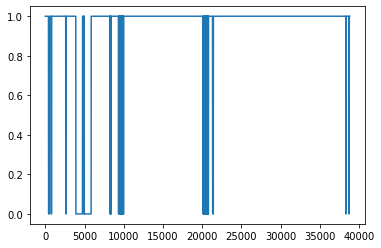

In [112]:
# print(data.shape)
# y_true[25000:35000] = y_pred[25000:35000]
# y_true[10000:20000] = y_pred[10000:20000]
# # select = np.array([[True] for i in range(data.shape[0])])
# # select[0:y_pred.shape[0],:] = y_pred!=y_true
# data['label'][time_step:-127]=y_true.flatten()


# # data = data[select]

# print(y_pred.flatten().shape)
# plt.plot(y_pred==y_true)
# data.to_csv('/media/ariac/DATAPART1/mrinmoys-document/test-and-eval-of-multi-agent-system/simulation_ws/src/pie/flightData/filtered_data/scenario5/scenario5_11.csv',index=False)
#     data = pd.read_csv(file)',index=False)

In [61]:
# MLP model
time_step = 32
num_feature = 7
num_class = 7
x_in = Input(shape=(num_feature*time_step),dtype="float32")
x = Dense(units=64, activation="relu")(x_in)
x = Dense(units=128, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
x = Dense(units=128, activation="relu")(x)
x = Dense(units=64, activation="relu")(x)
y = Dense(units=num_class, activation="softmax")(x)
model = Model(inputs=x_in, outputs=y)
optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
loss = losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=['CategoricalAccuracy'])

In [ ]:
#     for epoch in range(10):
#         j = 0
#         for (x_batch_train,y_batch_train,flag) in batch_gen(X_train, Y_train, time_step, 512):
# #             Process(j,model,loss_fn,x_batch_train,y_batch_train).start()
# #             j += 1
#             with tf.GradientTape() as tape:
#                 logits = model(x_batch_train, training=True)
#                 loss_value = loss_fn(y_batch_train, logits)
#             grads = tape.gradient(loss_value, model.trainable_weights)
            
#             optimizer.apply_gradients(zip(grads, model.trainable_weights))

#             # Update training metric.
#             train_acc_metric.update_state(y_batch_train, logits)
#             if flag==-1:
#                 break

#         # Display metrics at the end of each epoch.
#         train_acc = train_acc_metric.result()
#         print("Training acc over epoch: %.4f" % (float(train_acc),))

#         # Reset training metrics at the end of each epoch
#         train_acc_metric.reset_states()
#     if i==0:
#         break

In [82]:
print(model.summary())

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 7)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 256)           139264    
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 7)                 1799      
Total params: 141,063
Trainable params: 141,063
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
# plot_model(model=model,to_file="model.png")

In [64]:
# history = model.fit(batch_gen(X_train,Y_train,time_step,batch_size=32), epochs=100, verbose=2, shuffle=False)

In [45]:
#train
# # time_step = 0
# # model = load_model('lstm_model.h5')
# scaler = MinMaxScaler()
# encoder = OneHotEncoder()
# error = []
# for i,file in enumerate(database_file_names):
#     data = pd.read_csv(file)
#     X_train = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
#     X_train = X_train.values
#     Y_train = data['label'].values
#     Y_train = Y_train.reshape((-1,1))
#     if i == 0:
#         X_train = scaler.fit_transform(X_train)
#         Y_train = encoder.fit_transform(Y_train).toarray()
#     else:
#         X_train = scaler.transform(X_train)
#         Y_train = encoder.transform(Y_train).toarray()
    
# #     print(X_train.shape,Y_train.shape)
         
#     epoch = 0
#     er = []
#     #j = 0
#     hist = None
#     t1 = time.time()
#     for (x,y,flag) in batch_gen(X_train, Y_train, time_step, 512):
#         #j = j+1
#         #model.fit(x, y, epochs=1, verbose=2, shuffle=False)
# #         print(flag)
# #         print(x.shape,y.shape)
#         if flag == -1:
#             epoch += 1
#             print("epoch complete {}".format(epoch), hist)
#             print("This epoch took {} seconds".format(time.time()-t1))
#             error.append(np.mean(er))
#             er = []
#             model.save('lstm_model_f7.h5') 
#             t1 = time.time()
#         #if j%10000==0:
#         #    print(hist)
#         if epoch>10:
#             break
#         hist = model.train_on_batch(x,y)
#         er.append(hist[0])
# #         print(hist)
            
# plt.plot(error)
# plt.show()

In [45]:
# i=0
# for (x,y) in batch_gen(X_train,Y_train,time_step,32):
#     i=i+1
#     #model.fit(x, y, epochs=1, verbose=2, shuffle=False)
#     hist = model.test_on_batch(x,y)
#     if i%100==0:
#         print(hist)
#     if i>1000:
#         break
# print(error)
# model.save('lstm_model.h5')

In [80]:
file = database_file_names[1]
test_data = pd.read_csv(file)
X_test = test_data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
X_test = X_test.values

X_test = scaler.transform(X_test)
Y_test = test_data['label'].values
Y_test = Y_test.reshape((-1,1))

Y_test = encoder.transform(Y_test).toarray()

i=0
for (x,y_true,flag) in batch_gen_MLP(X_test,Y_test,time_step,Y_test.shape[0]):
    y = model.predict(x)
    y_pred = np.zeros(y.shape)
    y = np.argmax(y,axis=1)
    y_pred[np.arange(y_pred.shape[0]),y] = 1
    y_pred = encoder.inverse_transform(y_pred)
    y_true = encoder.inverse_transform(y_true)
    
    i=i+1
    if i==1:
#         print(y_true)
        print(accuracy_score(y_true,y_pred))
        print(classification_report(y_true,y_pred))
        print(confusion_matrix(y_true,y_pred))
        break
    
# Y_test = encoder.transform(Y_test).toarray()

0.09233338900952062


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

         Hold       0.09      1.00      0.17      5528
        Hover       0.00      0.00      0.00      1802
         Land       0.00      0.00      0.00       402
       Loiter       0.00      0.00      0.00      9866
Obstacleavoid       0.00      0.00      0.00      2402
       Search       0.00      0.00      0.00     39505
      Takeoff       0.00      0.00      0.00       365

     accuracy                           0.09     59870
    macro avg       0.01      0.14      0.02     59870
 weighted avg       0.01      0.09      0.02     59870

[[ 5528     0     0     0     0     0     0]
 [ 1802     0     0     0     0     0     0]
 [  402     0     0     0     0     0     0]
 [ 9866     0     0     0     0     0     0]
 [ 2402     0     0     0     0     0     0]
 [39505     0     0     0     0     0     0]
 [  365     0     0     0     0     0     0]]


In [19]:
# i=0
# for (x,y) in batch_gen(X_test,Y_test,time_step,32):
#     i=i+1
#     #model.fit(x, y, epochs=1, verbose=2, shuffle=False)
#     hist = model.test_on_batch(x,y)
#     if i%100==0:
#         print(hist)
#     if i>1000:
#         break

In [20]:
# print(model.predict(x))

In [21]:
# print(y)

In [36]:
x = np.array([[.1,.2,.3],[.7,.6,.3],[.2,.2,.6],[.2,.2,.6]]) 

In [37]:
print(np.argmax(x,axis=1))

[2 0 2 2]


In [17]:
y = np.zeros((3,3))
print(y)
indxs = np.argmax(x,axis=0)
print(indxs)
y[np.arange(3),indxs]=1
print(y)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[0 1 2]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [24]:
y_pred = np.eye(7)
print(encoder.inverse_transform(y_pred))

[['Hold']
 ['Hover']
 ['Land']
 ['Loiter']
 ['Obstacleavoid']
 ['Search']
 ['Takeoff']]


In [36]:
clf = tree.DecisionTreeClassifier(criterion='gini',#'entropy',#'gini', 
                                              splitter='best', 
                                              max_depth=None,#default None 
                                              min_samples_split=2, 
                                              min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, 
                                              max_features=None, 
                                              random_state=None, 
                                              max_leaf_nodes=None, 
                                              min_impurity_decrease=0.0, 
                                              min_impurity_split=None, 
                                              class_weight=None, 
                                              presort=False) 

In [45]:
#train decision tree
pwd = os.getcwd()
database_path = pwd[:-6] + "flightData/filtered_data/scenario5"
database_file_names = []
for root, dirs, files in os.walk(database_path):
    database_file_names = [os.path.join(root,file) for file in files]

scaler = MinMaxScaler()
train_data = None
for i,file in enumerate(database_file_names):
    data = pd.read_csv(file)
    if None is train_data:
        train_data = data
    else:
        train_data = pd.concat([train_data, data], ignore_index=True)
        
X_train = train_data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
X_train = X_train.values
Y_train = train_data['label'].values
Y_train = Y_train.reshape((-1,1))

X_train = scaler.fit_transform(X_train)

clf = clf.fit(X_train, Y_train) 
# classes = ['Hold','Hover','Takeoff','Loiter','Obstacleavoid',]#pd.unique(data['label'])

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=16)
    plt.yticks(tick_marks, classes,fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label',fontsize=16)
    return cm

In [50]:
pwd = os.getcwd()
database_path = pwd[:-6] + "flightData/filtered_data/scenario5"
database_file_names = []
for root, dirs, files in os.walk(database_path):
    database_file_names = [os.path.join(root,file) for file in files]
classes = ['Hold','Hover','Land','Loiter','Obstacleavoid','Search','Takeoff']#pd.unique(data['label'])
for i,file in enumerate(database_file_names):
    data = pd.read_csv(file)
    X_test = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
    
#     X_test = X_test.apply(lambda x: pd.to_numeric(x, errors='coerce'))
#     rows_with_nan = [index for index, row in X_test.iterrows() if row.isnull().any()]
#     X_test = X_test.drop(rows_with_nan)
    
    X_test = X_test.values
#     data = data.drop(rows_with_nan)
    Y_test = data['label'].values
    y_true = Y_test.reshape((-1,1))
    X_test = scaler.transform(X_test)
    y_pred = clf.predict(X_test) 
#     print(classification_report(y_true,y_pred))
    print(accuracy_score(y_true,y_pred))
#     conf_mat = confusion_matrix(y_true,y_pred)
#     print(conf_mat)
#     plt.figure(figsize=(6,6))
#     cm_non_normalized = plot_confusion_matrix(conf_mat, classes=classes, normalize=True,
#                       title='Normalized confusion matrix')
    #if i==0:
    #    break
# plt.show()

0.9999353211305866
0.9998998363994525
0.9999309111949772
0.9999455500803136
0.9999282588420977


In [19]:
pwd = os.getcwd()
time_step = 128
model_path = pwd+'/models/'
# model_name = 'lstm_direction_2_layers_1_features_7_neurons_64_timesteps_128_epochs_290.h5'#'lstm_model_blstm_' + str(50*10) + '.h5'
# model = load_model(model_path+model_name)

file = '/media/ariac/DATAPART1/mrinmoys-document/ros-intel-uav-rpeo/\
simulation_ws/src/pie/flightData/custom_uav_data/custom_uav2_scenario2.csv'
data = pd.read_csv(file)
data = data[data['label']!='Search']
X_test = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
X_test = X_test.values
Y_test = data['label'].values
Y_test = Y_test.reshape((-1,1))

X_test = scaler.transform(X_test)
Y_test = encoder.transform(Y_test).toarray()

input_data = X_test[:-time_step,:]
targets = Y_test[time_step:,:]
dataset = timeseries_dataset_from_array(input_data, 
                                        targets, 
                                        sequence_length=time_step,
                                        batch_size=128)
#'''

for loop in range(20):
    hist = model.fit(dataset,
                     epochs=10,
                     verbose=2,
                     callbacks=None,#[batch_print_callback],
                     max_queue_size=512,
                     workers=80,
                     use_multiprocessing=True)
#'''
    #         hist = model.evaluate(dataset,
    #                               verbose=1,
    #                               callbacks=None,#[batch_print_callback],
    #                               max_queue_size=512,
    #                               workers=80,
    #                               use_multiprocessing=True,
    #                               return_dict=True)

    y_pred = model.predict(dataset,
                          verbose=1,
                          callbacks=None,#[batch_print_callback],
                          max_queue_size=512,
                          workers=80,
                          use_multiprocessing=True)

    y_pred = encoder.inverse_transform(y_pred)
    y_true = encoder.inverse_transform(targets[0:y_pred.shape[0],:])
    print(accuracy_score(y_true,y_pred))
    print(classification_report(y_true,y_pred))
    print(confusion_matrix(y_true,y_pred))

Epoch 1/10
64/64 - 2s - loss: 0.4490 - categorical_accuracy: 0.8415
Epoch 2/10
64/64 - 2s - loss: 0.2761 - categorical_accuracy: 0.9438
Epoch 3/10
64/64 - 2s - loss: 0.2418 - categorical_accuracy: 0.9261
Epoch 4/10
64/64 - 2s - loss: 0.2007 - categorical_accuracy: 0.9501
Epoch 5/10
64/64 - 2s - loss: 0.2023 - categorical_accuracy: 0.9403
Epoch 6/10
64/64 - 2s - loss: 0.1751 - categorical_accuracy: 0.9527
Epoch 7/10
64/64 - 2s - loss: 0.1820 - categorical_accuracy: 0.9435
Epoch 8/10
64/64 - 2s - loss: 0.1584 - categorical_accuracy: 0.9545
Epoch 9/10
64/64 - 2s - loss: 0.1668 - categorical_accuracy: 0.9475
Epoch 10/10
64/64 - 2s - loss: 0.1441 - categorical_accuracy: 0.9567
64/64 [==============================] - 1s 14ms/step
0.9645766477412985
              precision    recall  f1-score   support

        Hold       0.99      1.00      0.99      3979
       Hover       0.94      1.00      0.96      3315
        Land       0.96      0.65      0.77       632
     Takeoff       1.00      

Epoch 9/10
64/64 - 2s - loss: 0.0668 - categorical_accuracy: 0.9867
Epoch 10/10
64/64 - 2s - loss: 0.0667 - categorical_accuracy: 0.9835
64/64 [==============================] - 1s 14ms/step
0.9876573685509751
              precision    recall  f1-score   support

        Hold       0.99      1.00      0.99      3979
       Hover       0.99      0.99      0.99      3315
        Land       0.96      0.95      0.96       632
     Takeoff       1.00      0.74      0.85       176

    accuracy                           0.99      8102
   macro avg       0.98      0.92      0.95      8102
weighted avg       0.99      0.99      0.99      8102

[[3979    0    0    0]
 [   0 3289   26    0]
 [   0   29  603    0]
 [  45    0    0  131]]
Epoch 1/10
64/64 - 2s - loss: 0.0763 - categorical_accuracy: 0.9801
Epoch 2/10
64/64 - 2s - loss: 0.0727 - categorical_accuracy: 0.9828
Epoch 3/10
64/64 - 2s - loss: 0.0882 - categorical_accuracy: 0.9662
Epoch 4/10
64/64 - 2s - loss: 0.1333 - categorical_accurac

[[3979    0    0    0]
 [   0 3287   25    3]
 [   0   46  586    0]
 [  44    2    0  130]]
Epoch 1/10
64/64 - 2s - loss: 0.0619 - categorical_accuracy: 0.9846
Epoch 2/10
64/64 - 2s - loss: 0.0601 - categorical_accuracy: 0.9852
Epoch 3/10
64/64 - 2s - loss: 0.0588 - categorical_accuracy: 0.9853
Epoch 4/10
64/64 - 2s - loss: 0.0573 - categorical_accuracy: 0.9862
Epoch 5/10
64/64 - 2s - loss: 0.0562 - categorical_accuracy: 0.9861
Epoch 6/10
64/64 - 2s - loss: 0.0554 - categorical_accuracy: 0.9859
Epoch 7/10
64/64 - 2s - loss: 0.0540 - categorical_accuracy: 0.9868
Epoch 8/10
64/64 - 2s - loss: 0.0525 - categorical_accuracy: 0.9869
Epoch 9/10
64/64 - 2s - loss: 0.0516 - categorical_accuracy: 0.9870
Epoch 10/10
64/64 - 2s - loss: 0.0500 - categorical_accuracy: 0.9878
64/64 [==============================] - 1s 13ms/step
0.9896321895828191
              precision    recall  f1-score   support

        Hold       0.99      1.00      0.99      3979
       Hover       0.99      1.00      0.99 

64/64 - 2s - loss: 0.2111 - categorical_accuracy: 0.9510
Epoch 8/10
64/64 - 2s - loss: 0.1834 - categorical_accuracy: 0.9573
Epoch 9/10
64/64 - 2s - loss: 0.1633 - categorical_accuracy: 0.9645
Epoch 10/10
64/64 - 2s - loss: 0.1605 - categorical_accuracy: 0.9615
64/64 [==============================] - 1s 13ms/step
0.9576647741298445
              precision    recall  f1-score   support

        Hold       0.99      1.00      0.99      3979
       Hover       0.93      0.98      0.96      3315
        Land       0.85      0.64      0.73       632
     Takeoff       1.00      0.76      0.86       176

    accuracy                           0.96      8102
   macro avg       0.94      0.84      0.89      8102
weighted avg       0.96      0.96      0.96      8102

[[3979    0    0    0]
 [   0 3242   73    0]
 [   0  228  404    0]
 [  42    0    0  134]]
